<b><font size="5">Converting Elevation Gain from AllTrails GPS Data to Match Topographic Data</font></b>

AllTrails is notorious for having inaccurate elevation gain data. This is because a hiker's GPS data is used to determine a trail's elevation gain. Noise in the GPS data leads to inflated elevation gain values, particularily for flat trails. I looked up some trails on AllTrails similar to those I've completed. For each, I looked up the matching route on Komoot to find the trail's elevation gain according to topographic data. The elevation gain from the topographic data is treated as the true elevation gain. Here, I compare the topographic and GPS values of elevation gain. Through trial and error, I find a way to convert the GPS data to approximate align with the topographic data. Ultimately, I find it to be related to slope.

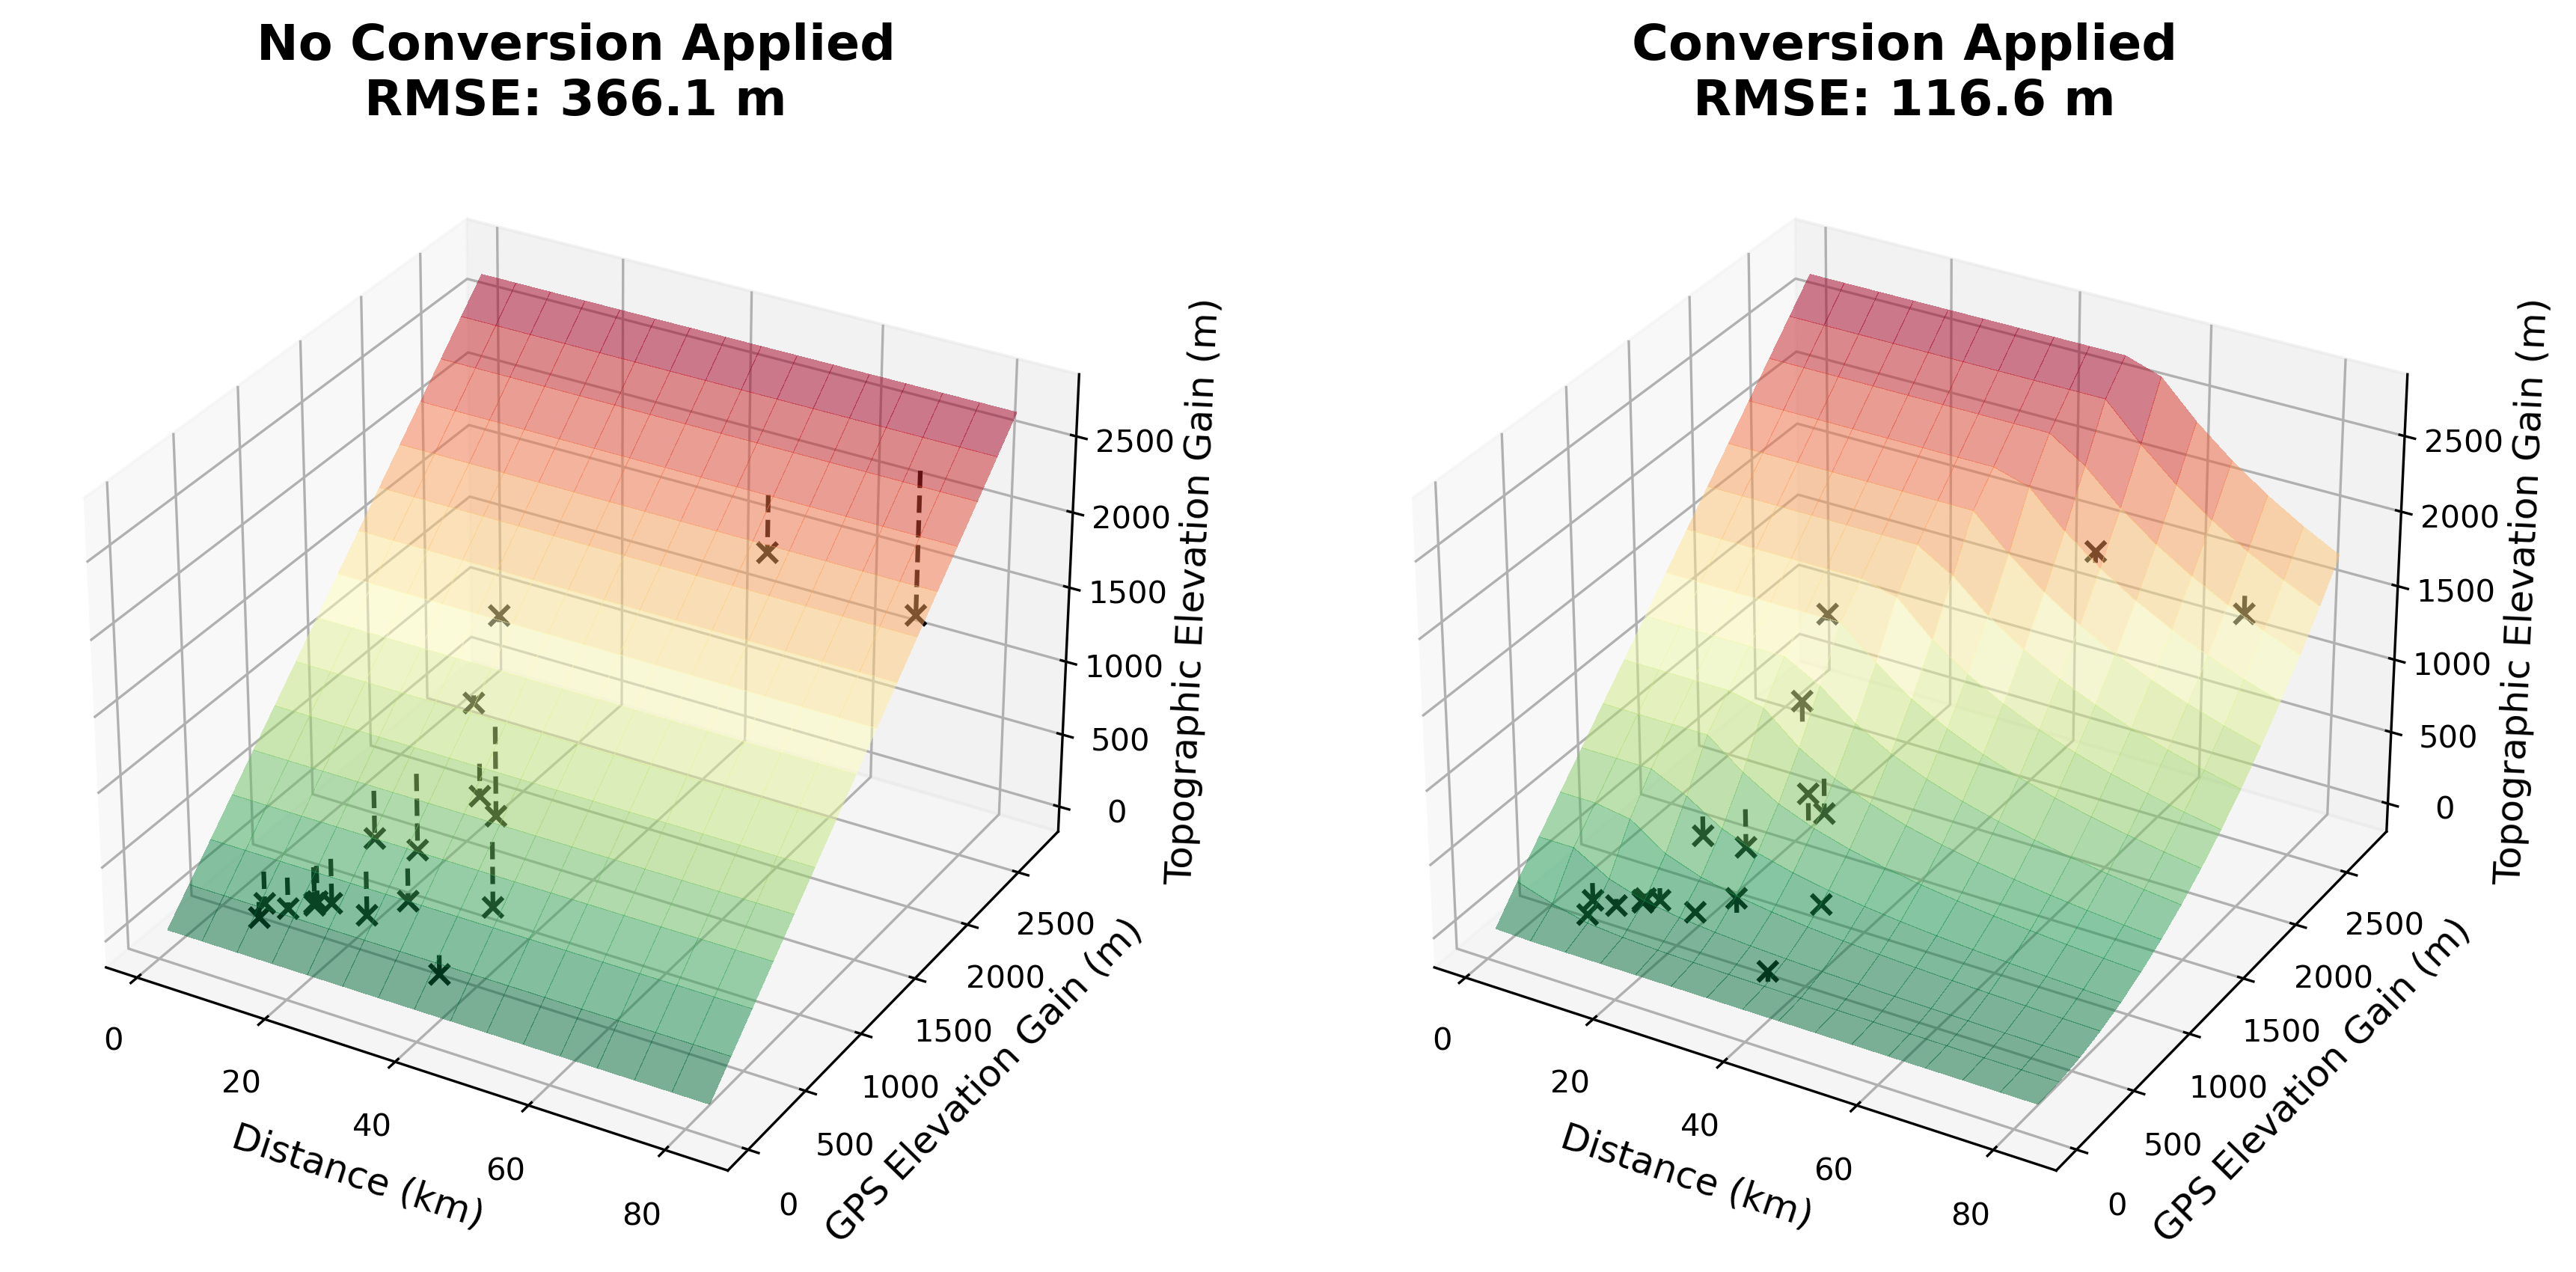

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.cm as cm

def convertGPS2Topo(dist, gpsGain, apply=True):    
    slope = gpsGain/dist
    
    if apply:
        topoGain = gpsGain*(slope/50)
    else:
        topoGain = gpsGain
        
    gainDelta = gpsGain - topoGain
    
    # if slope is beyond the slope slope of the Grand Canyon, apply no change
    return (1 - np.maximum(gainDelta/gpsGain, 0))*gpsGain

# fetching data
trails = pd.read_csv('dataSources/ElevationGainSources.csv', engine='python')
trails['slope'] = trails.gps_gain/trails.distance

fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d"})

x = trails.distance
y = trails.gps_gain
z = trails.topo_gain
distMin = x.min()*0.1
distMax = x.max()*1.2
gainMin = y.min()*0.1
gainMax = y.max()*1.2
gridDim = 16
dists = np.arange(distMin, distMax, (distMax - distMin)/gridDim)
gpsGains = np.arange(gainMin, gainMax, (gainMax - gainMin)/gridDim)
dists, gpsGains = np.meshgrid(dists, gpsGains)

for i, axi in enumerate(ax):
    axi.scatter(x, y, z, c='k', alpha=1, s=40, marker='x')
    
    if i == 0:
        Z = convertGPS2Topo(dists, gpsGains, apply=False)
        title = 'No Conversion Applied\n'
    else:
        Z = convertGPS2Topo(dists, gpsGains)
        title = 'Conversion Applied\n'

    DS_sum = 0
    for j in range(len(x)):
        interpolated_z = griddata((dists.flatten(), gpsGains.flatten()), Z.flatten(), (x[j], y[j]), method='linear')
        DS_sum += (interpolated_z - z[j])**2
        axi.plot([x[j], x[j]], [y[j], y[j]], [interpolated_z, z[j]], c='k', ls='--')
    RMSE = np.sqrt(DS_sum/len(x))
    
    axi.set_title(f"{title}RMSE: {round(RMSE,1)} m", size=16, fontweight='bold')

    axi.plot_surface(dists, gpsGains, Z, cmap=cm.RdYlGn_r, alpha=0.5, antialiased=False)
    axi.view_init(30, -60)
    
    axi.set_xlabel('Distance (km)', size=12)
    axi.set_ylabel('GPS Elevation Gain (m)', size=12)
    axi.set_zlabel('Topographic Elevation Gain (m)', size=12)

fig.set_dpi(300)
fig.set_size_inches(14, 7)
bgColor = 'w'
plt.rcParams['axes.facecolor'] = bgColor
fig.patch.set_facecolor(bgColor)

plt.savefig(f'images/GPStoTopographicElevationGain', bbox_inches='tight')
plt.show()